In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm


In [2]:
def LOG_filter(sigma=1.0, normalize=False):
    # set the filter size proportional to sigma
    kernel_size = int(2 * np.ceil(3*sigma) + 1)
    # construct a 2d gaussian jernel by taking outer product of 2 1d gaussian kernels
    gaussian_1d = cv2.getGaussianKernel(kernel_size, sigma)
    # compute outer product of the two 1d kernels to get the 2d gaussian kernels
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    # apply laplacian operator to get LOG filter
    LOG_filter = cv2.Laplacian(gaussian_2d, cv2.CV_64F)
    
    if normalize:
        LOG_filter = sigma * sigma * LOG_filter
    
    return LOG_filter 

#### Now load a test imagve and convolve with the NLOG kernel

(903, 905)


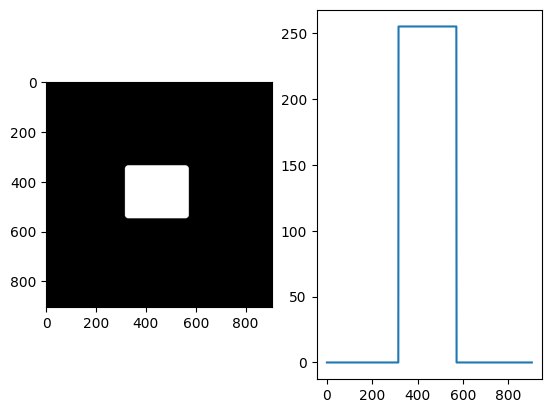

In [91]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = np.array(cv2.imread("./square1.png", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img.shape)

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
#plt.axis('off')

plt.subplot(1,2,2)
plt.plot(img[450,:])
plt.show()


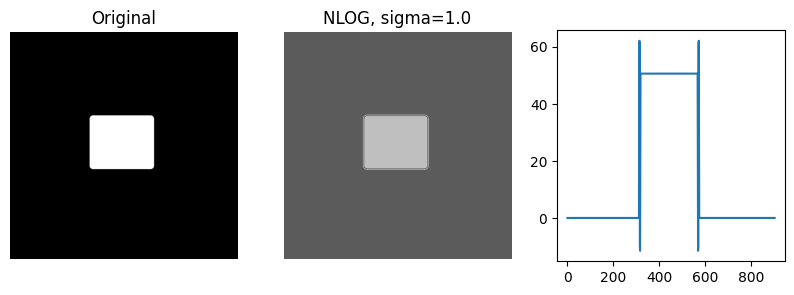

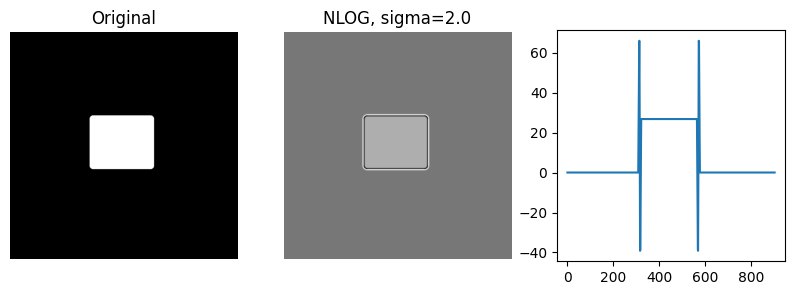

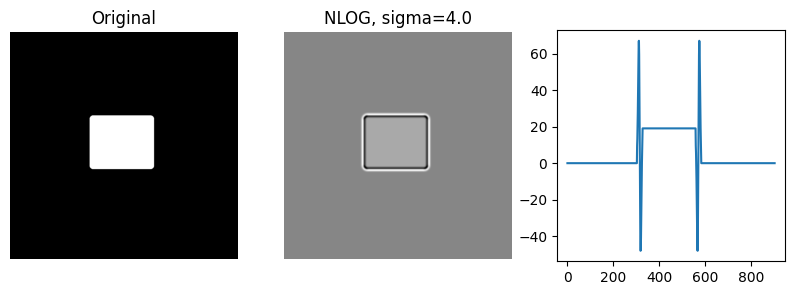

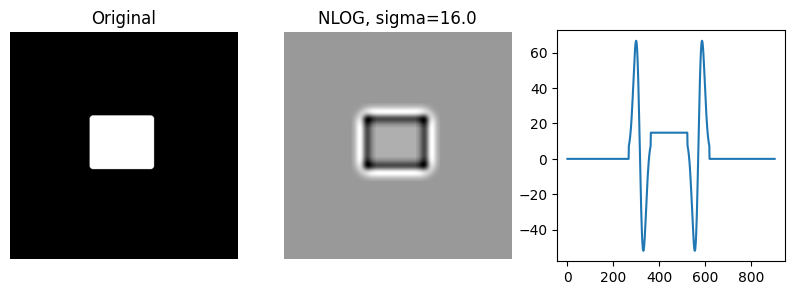

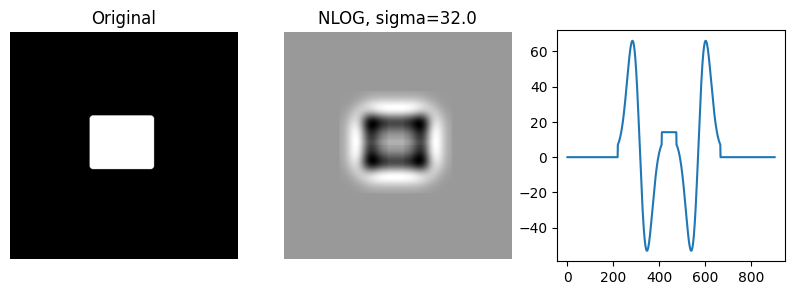

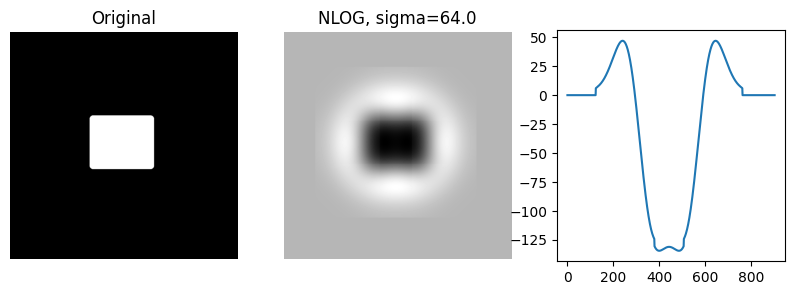

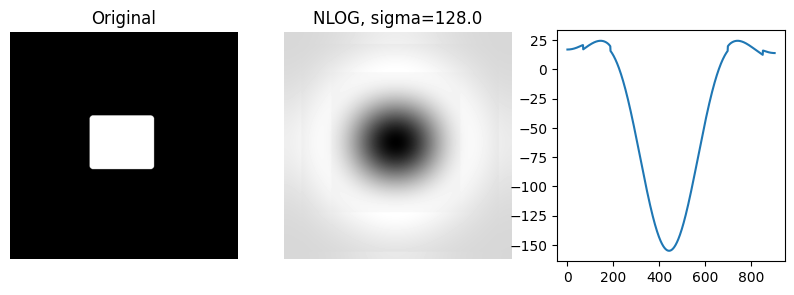

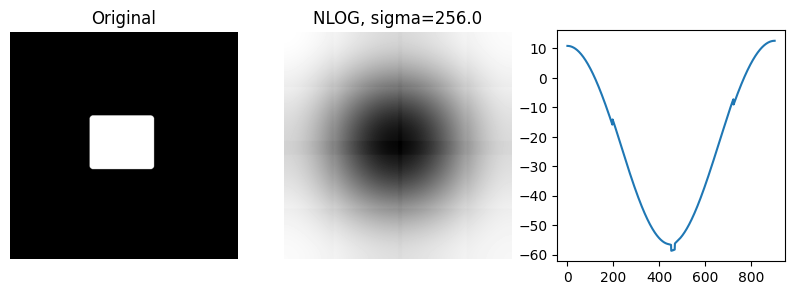

In [97]:
# apply NLOG to the image with different sigma values
sigmas = [1.0, 2.0, 4.0, 16.0, 32.0, 64.0, 128.0, 256.0]
NLOG_stack = []
for sigma in sigmas:

    filter = LOG_filter(sigma=sigma, normalize=True)
    img_log =  cv2.filter2D(img, -1, filter, cv2.CV_64F)
    NLOG_stack.append(img_log)

    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_log, cmap='gray')
    plt.title('NLOG, sigma='+str(sigma))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.plot(img_log[450,:])
    plt.show()





#### We've applied the NLOG operator at different scales/sigma values. Note that for $\sigma = 128$, we get a large peak near the pixel coordinates (450, 450). This indicates that a blob of size $\approx 2*\sigma = 256$ centered at that location has been detected. This detected blob is just the white square in the middle of the image.

#### Now let's try a test image that contains multiple blobs.

(1004, 1052)


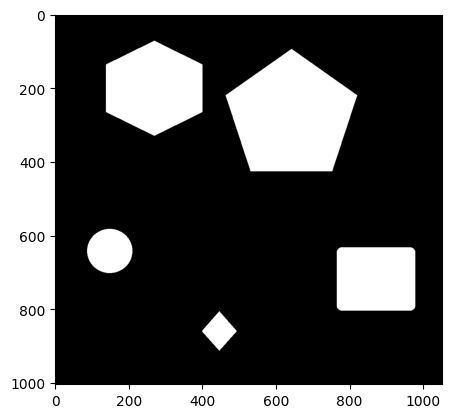

In [3]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img2 = np.array(cv2.imread("./blobs.png", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img2.shape)

plt.imshow(img2, cmap='gray')
#plt.axis('off')


In [4]:
def find_peaks(arr, num_peaks=5, threshold=0.9, non_max_suppression=False):
    arr_abs = np.abs(arr)

    # apply thresholding to remove weaker peaks
    arr_abs[arr_abs < threshold*np.max(arr_abs)] = 0.0

    # apply non-maximum suppression
    if non_max_suppression:
        w2 = 15 #int(0.1*np.sqrt(arr.shape[0]*arr.shape[1])) # window half-size
        for i in range(w2, arr_abs.shape[0]-w2):
            for j in range(w2, arr_abs.shape[1]-w2):
                patch = arr_abs[i-w2:i+w2, j-w2:j+w2]
                maxval = np.max(patch)
                patch[patch < maxval] = 0
                arr_abs[i-w2:i+w2, j-w2:j+w2] = patch


    flat_indices = np.argpartition(arr_abs, -num_peaks, axis=None)[-num_peaks:]

    # Sort the indices based on the corresponding values
    sorted_indices = flat_indices[np.argsort(arr_abs.flat[flat_indices])]

    # Convert the sorted flat indices to row and column indices
    row_indices, col_indices = np.unravel_index(sorted_indices, arr_abs.shape)

    peaks = []
    for i in range(len(row_indices)):
        peak = (col_indices[i], row_indices[i])
        peaks.append([peak,  arr_abs[row_indices[i], col_indices[i]]])

    return peaks

Sigma = 10.0, Peaks = [[(445, 823), 105.48507]]


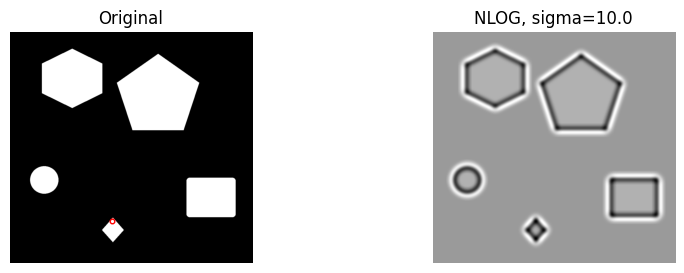

Sigma = 25.0, Peaks = [[(445, 860), 177.86021]]


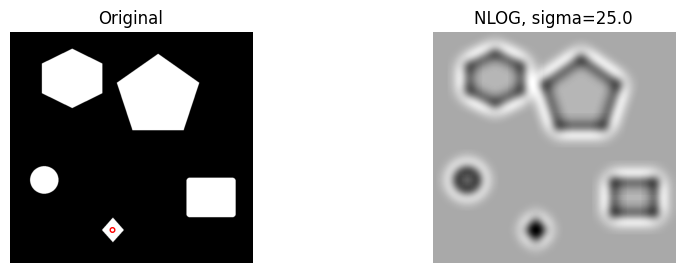

Sigma = 50.0, Peaks = [[(148, 643), 180.84535]]


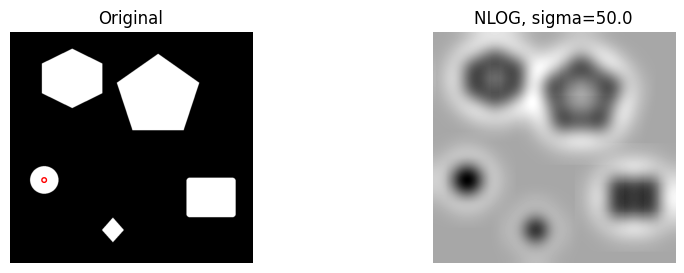

Sigma = 75.0, Peaks = [[(870, 719), 182.22322]]


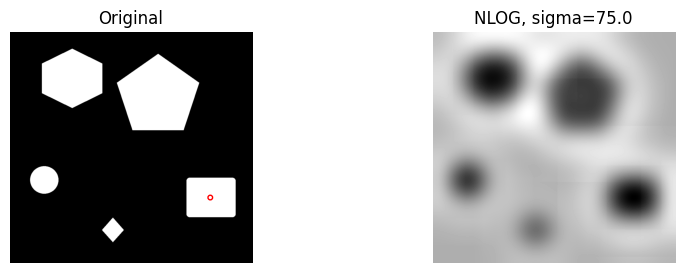

Sigma = 85.0, Peaks = [[(870, 719), 178.55132]]


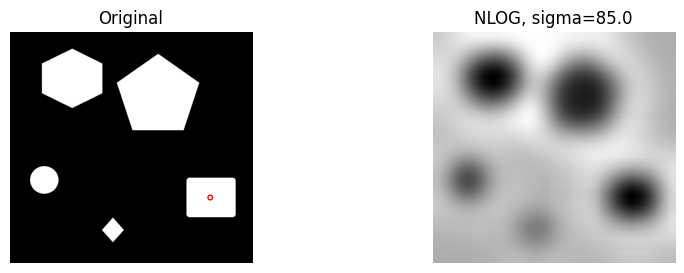

Sigma = 92.0, Peaks = [[(261, 204), 176.05214]]


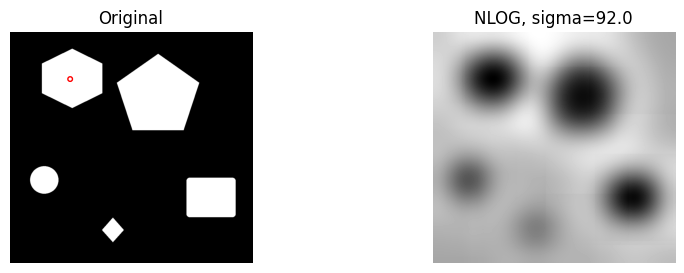

Sigma = 100.0, Peaks = [[(649, 280), 172.99886]]


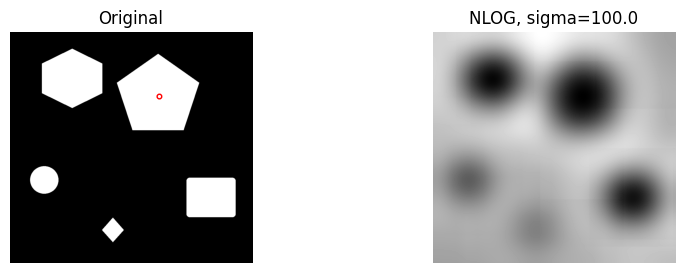

Sigma = 150.0, Peaks = [[(647, 285), 138.68007]]


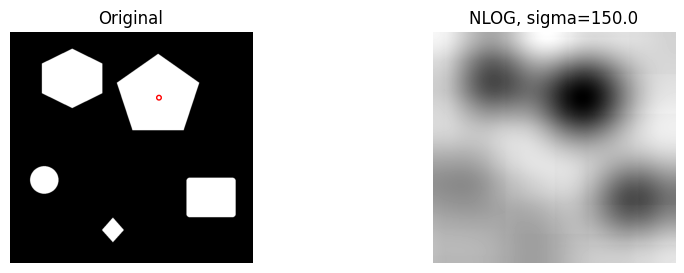

Sigma = 256.0, Peaks = [[(1051, 0), 70.41362]]


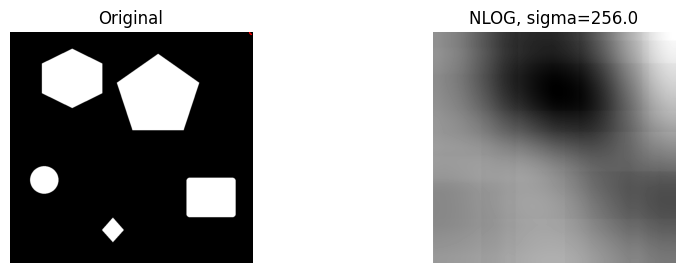

In [140]:
# apply NLOG to the image with different sigma values
sigmas = [10.0, 25.0, 50.0, 75.0, 85.0, 92.0, 100.0, 150.0, 256.0]
#NLOG_stack = []
for sigma in sigmas:

    filter = LOG_filter(sigma=sigma, normalize=True)
    img2_log =  cv2.filter2D(img2, -1, filter, cv2.CV_64F)
    #NLOG_stack.append(img2_log)

    # find the peaks
    peaks = find_peaks(img2_log, num_peaks=1, non_max_suppression=True)

    print(f"Sigma = {sigma}, Peaks = {peaks}")

    plt.figure(figsize=(10,3))

    plt.subplot(1,2,1)
    plt.imshow(img2, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # add a little circle at each peak location
    for peak in peaks:
        circle = patches.Circle(peak[0], radius=10, edgecolor='red', facecolor='none')
        plt.gca().add_patch(circle)


    plt.subplot(1,2,2)
    plt.imshow(img2_log, cmap='gray')
    plt.title('NLOG, sigma='+str(sigma))
    plt.axis('off')
    

    plt.show()



#### Scale Invariant Feature Detctor (SIFT): This is just a blob detection algorithm that has the following steps:

1) Compute NLOG of the image over a wide range of scales/sigma values
2) Concateneate all these NLOG outputs to create a 3d array: $(x,y,\sigma)$
3) Apply some thresholding to get rid of weaker values
4) Use non-maximal suppression inside a cubic window, e.g. a 3x3x3 window, to extract the local maxima $(x_*, y_*, \sigma_*)$, these are the SIFT features/blobs



In [14]:
# this function takes the absolute value of an array and suppresses all non-maximal values within a specified neighborhood size
def non_maximal_suppression(arr, window_size=5):
    w2 = int(window_size/2)  # window half-size

    for i in range(w2, arr.shape[0]-w2):
        for j in range(w2, arr.shape[1]-w2):
            patch = arr[i-w2:i+w2, j-w2:j+w2]
            maxval = np.max(patch)
            patch[patch < maxval] = 0
            arr[i-w2:i+w2, j-w2:j+w2] = patch

    return arr        


# this function gets all indices of non-zero values in a 2d array along with the value
def get_peaks(arr, sigma, num_peaks=10):

    flat_indices = np.argpartition(arr, -num_peaks, axis=None)[-num_peaks:]

    # Sort the indices based on the corresponding values
    sorted_indices = flat_indices[np.argsort(arr.flat[flat_indices])]

    # Convert the sorted flat indices to row and column indices
    row_indices, col_indices = np.unravel_index(sorted_indices, arr.shape)

    peaks = []
    for i in range(len(row_indices)):
        val = arr[row_indices[i], col_indices[i]]

        # exlude zero values, we only care about maximal values
        if val > 0.0:
            peak = (col_indices[i], row_indices[i])
            peaks.append([peak, sigma, val])

    return peaks        



def plot_SIFT(img, blobs):
    plt.figure(figsize=(7,8))
    plt.imshow(img, cmap='gray')
    plt.title('SIFT Blobs')
    plt.axis('off')

    blob_vals = [b[2] for b in blobs]

    # create a color map
    colormap = 'viridis'
    norm = colors.Normalize(vmin=np.min(blob_vals), vmax=np.max(blob_vals)) # Normalize the blob scalar values
                       
    # add a little circle at each blob location
    for blob in blobs:
        blob_position = blob[0]
        blob_scale = 2*blob[1]    # 2* sigma
        blob_value = blob[2]
        
        circle = patches.Circle(blob_position, radius=blob_scale, edgecolor=cm.get_cmap(colormap)(norm(blob_value)), facecolor='none')
        plt.gca().add_patch(circle)

    # inlcude colorbar
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    cbar = plt.colorbar(sm)
    cbar.set_label('Blob Intensities')

    plt.show()


# make sure the input image is float and not uint
def SIFT(img, num_scales=30, threshold=0.9, window_size=3, max_blob_size=0.1, num_blobs_per_scale=40, supression=True, showBlobs=False):
    # specify range of sigmas
    sigmas = np.linspace(1.0, max_blob_size*np.sqrt(img.shape[0]**2 + img.shape[1]**2), num_scales)
    #print(f"sigmas: {sigmas}")

    # iterate over sigmas
    img_nlogs = []
    for sigma in sigmas:
        # compute NLOGS
        filter = LOG_filter(sigma=sigma, normalize=True)
        nlog =  cv2.filter2D(img, -1, filter, cv2.CV_64F)
        img_nlogs.append(nlog)

    # concatenate all the nlogs and take the absolute value
    nlog_stack = np.abs(np.stack(img_nlogs, axis=0)) 

    # now apply non maximal suppression
    if supression:
        nlog_stack = non_maximal_suppression(nlog_stack, window_size=window_size)

    # apply thresholding
    maxval = np.max(nlog_stack)
    nlog_stack[nlog_stack < threshold * maxval] = 0.0

    # now scan each sigma level and get the blobs
    SIFT_blobs = []
    for i, sigma in enumerate(sigmas):
        blobs = get_peaks(nlog_stack[i,:,:], sigma, num_peaks=num_blobs_per_scale)
        if showBlobs:
            print(f"Sigma: {sigma}, blobs {blobs}")
        SIFT_blobs += blobs

    # show a plot 
    plot_SIFT(img, SIFT_blobs)

    return SIFT_blobs


# altermnate version of SIFT thta uses difference of gaussians instead of nlogs
def SIFT_DoG(img, num_scales=30, threshold=0.9, window_size=3, max_blob_size=0.1, num_blobs_per_scale=40, supression=True, showBlobs=False):
    # specify range of sigmas
    sigmas = np.linspace(1.0, max_blob_size*np.sqrt(img.shape[0]**2 + img.shape[1]**2), num_scales)
    #print(f"sigmas: {sigmas}")

    # iterate over sigmas
    img_gaussian = []
    for sigma in sigmas:
        # compute gaussian filtered images
        kernel_size = int(2 * np.ceil(3*sigma) + 1)
        img_gaussian.append(cv2.GaussianBlur(img, (kernel_size,kernel_size), sigma))

    # compute normalized difference of gaussians (DoG)
    img_DoG = []
    for i in range(1, len(img_gaussian)):
        img_gaussian_difference =  (img_gaussian[i] - img_gaussian[i-1]) / ((sigmas[i]/sigmas[i-1])-1.0)
        img_DoG.append(img_gaussian_difference)

    # concatenate all the DoGs and take the absolute value
    DoG_stack = np.abs(np.stack(img_DoG, axis=0)) 

    # now apply non maximal suppression
    if supression:
        DoG_stack = non_maximal_suppression(DoG_stack, window_size=window_size)

    # apply thresholding
    maxval = np.max(DoG_stack)
    DoG_stack[DoG_stack < threshold * maxval] = 0.0

    # now scan each sigma level and get the blobs
    SIFT_blobs = []
    for i, sigma in enumerate(sigmas[0:-1]):
        blobs = get_peaks(DoG_stack[i,:,:], sigma, num_peaks=num_blobs_per_scale)
        if showBlobs:
            print(f"Sigma: {sigma}, blobs {blobs}")
        SIFT_blobs += blobs

    # show a plot 
    plot_SIFT(img, SIFT_blobs)

    return SIFT_blobs    

/tmp/ipykernel_237266/2898883906.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  circle = patches.Circle(blob_position, radius=blob_scale, edgecolor=cm.get_cmap(colormap)(norm(blob_value)), facecolor='none')
/tmp/ipykernel_237266/2898883906.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


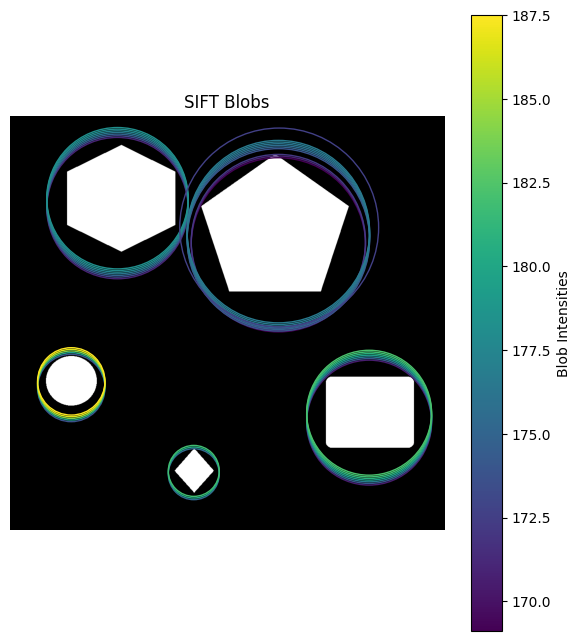

In [15]:
SIFT_blobs = SIFT(img2, window_size=5)

/tmp/ipykernel_237266/2898883906.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  circle = patches.Circle(blob_position, radius=blob_scale, edgecolor=cm.get_cmap(colormap)(norm(blob_value)), facecolor='none')
/tmp/ipykernel_237266/2898883906.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


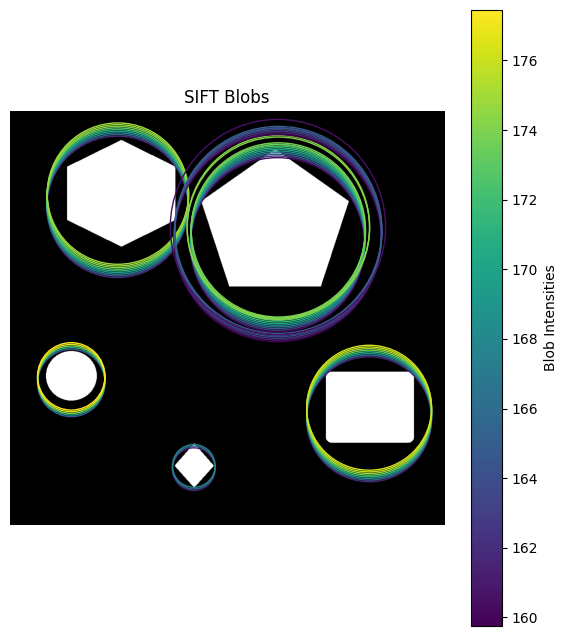

In [16]:
# using DoG instead
SIFT_blobs = SIFT_DoG(img2, window_size=5)

#### The blob detector seems to be working well! The radius of each circle is $2 \sigma$ which is the rough size of the blob

#### Now let's try some other test images

(384, 512)


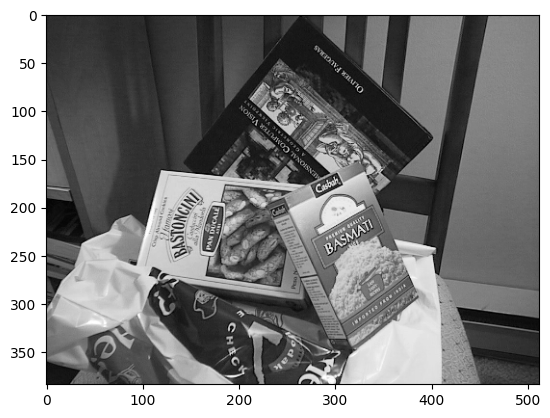

In [9]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img3 = np.array(cv2.imread("./box_in_scene.png", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img3.shape)

plt.imshow(img3, cmap='gray')
#plt.axis('off')

/tmp/ipykernel_237266/2898883906.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  circle = patches.Circle(blob_position, radius=blob_scale, edgecolor=cm.get_cmap(colormap)(norm(blob_value)), facecolor='none')
/tmp/ipykernel_237266/2898883906.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


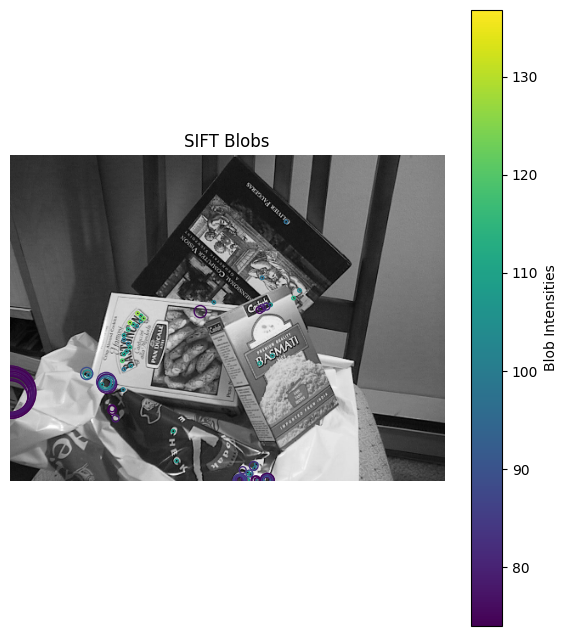

In [22]:
SIFT_blobs = SIFT(img3, threshold=0.54, window_size=3, max_blob_size=0.025, supression=True)

/tmp/ipykernel_237266/2898883906.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  circle = patches.Circle(blob_position, radius=blob_scale, edgecolor=cm.get_cmap(colormap)(norm(blob_value)), facecolor='none')
/tmp/ipykernel_237266/2898883906.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


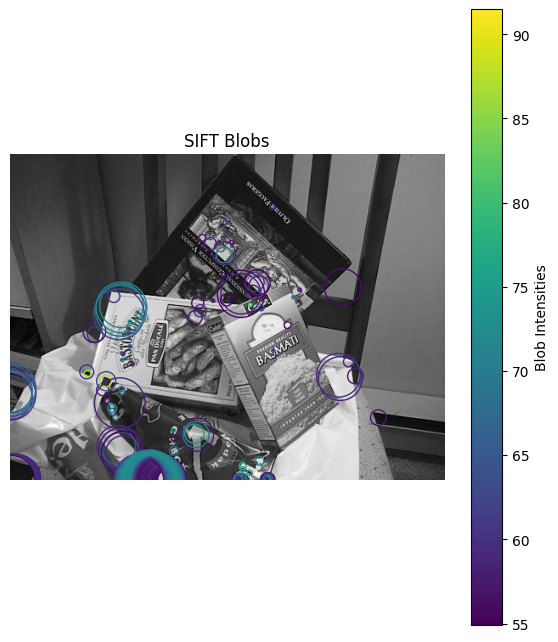

In [25]:
SIFT_blobs = SIFT_DoG(img3, threshold=0.6, window_size=5, max_blob_size=0.025, supression=True)

(4500, 8000)


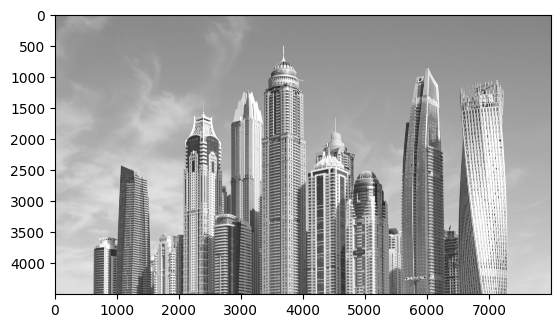

In [26]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img4 = np.array(cv2.imread("./skyscrapers.jpg", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img4.shape)

plt.imshow(img4, cmap='gray')
plt.show()
#plt.axis('off')

SIFT_blobs = SIFT_DoG(img4, threshold=0.75, window_size=5, max_blob_size=0.2, supression=False)